In [1]:
##############
### Import ###
##############

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 25})

from scipy.optimize import curve_fit

#Astropy
import astropy
from astropy.io import fits
from astropy.table import Table

# Matplotlib
import matplotlib
import matplotlib.pyplot as plt
# %matplotlib inline
matplotlib.rcParams.update({'font.size': 25})

#Numpy/Scipy
import numpy as np
from scipy.interpolate import InterpolatedUnivariateSpline as IUS

import numpy as np
import astropy
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm_notebook

In [2]:
leff = {'BP':0.5387,'G':0.6419,'RP':0.7667,'J':1.2345,'H':1.6393,'K':2.1757}
def ccm_a(x):
    '''
    a(x) function from Cardelli et al. 1989
    
    Input:
    -----
        x: effective wavelength in units of 1/micron
        
    Output:
    ------
        a: a function value  
    '''
    if 0.3 <= x < 1.1:
        a = 0.574*(x**1.61)
        return a
    
    elif 1.1 <= x < 3.3:
        y = x - 1.82
        a = (1.+0.17699*y-0.50477*(y**2)-0.02427*(y**3)+0.72085*(y**4)+
                0.01979*(y**5)-0.77530*(y**6)+0.32999*(y**7))
        return a
    
    elif 3.3 <= x < 8.0:
        if x < 5.9:
            a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)
            return a
        
        else:
            fa = -0.04473*((x-5.9)**2)+0.1207*((x-5.9)**3)
            a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)+fa
            return a       
    
def ccm_b(x):
    '''
    b(x) function from Cardelli et al. 1989
    
    Input:
    -----
        x: effective wavelength in units of 1/micron
        
    Output:
    ------
        b: b function value 
    '''
    if 0.3 <= x < 1.1:
        b = -0.527*(x**1.61)
        return b
    
    elif 1.1 <= x <= 3.3:
        y = x - 1.82
        b = (1.41338*y+2.28305*(y**2)+1.07233*(y**3)-5.38434*(y**4)-
                0.62251*(y**5)+5.30260*(y**6)-2.09002*(y**7))
        return b
    
    elif 3.3 <= x < 8.0:
        if x < 5.9:
            b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)
            return b
        
        else:
            fb = 0.2130*((x-5.9)**2)+0.1207*((x-5.9)**3)
            b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)+fb
            return b
    
def ccm_alav(wave,rv):
    '''
    Calculate A\lambda/Av
    
    Inputs:
    ------
        wave: effective wavelength in units of micron
        rv: Rv value (=Av/E(B_V))
        
    Output:
    ------
        alav: A\lambda/Av
    '''
    x=1/wave
    alav = ccm_a(x)+ccm_b(x)/rv
    return alav

ejk_ak = (ccm_alav(leff['J'],3.1)-ccm_alav(leff['K'],3.1))/ccm_alav(leff['K'],3.1)
ebv_ak = (ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))/ccm_alav(leff['K'],3.1)

def closest(data,value):
    '''
    Find nearest value in array to given value
        
    Inputs:
    ------
        data: data to search through 
        value: value of interest
    '''
        
    data = np.asarray(data)
    return data[(np.abs(np.subtract(data,value))).argmin()]

def mad(dat):
    return np.nanmedian(np.abs(dat-np.nanmedian(dat)))

abp_ebv = ccm_alav(leff['BP'],3.1)/(ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))
arp_ebv = ccm_alav(leff['RP'],3.1)/(ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))
aj_ebv = ccm_alav(leff['J'],3.1)/(ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))
ah_ebv = ccm_alav(leff['H'],3.1)/(ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))
ak_ebv = ccm_alav(leff['K'],3.1)/(ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))

# PARSEC

In [3]:
massive = fits.getdata('/Users/joshuapovick/Desktop/Research/parsec/parsec_massive_3_5.fits.gz')
massive = Table(massive[np.where(massive['label']==3.0)])
massive['index'] = np.arange(len(massive))
massive = massive[np.argsort(massive['logAge'])]
massive = massive['index','MH','logAge','logTe','logg','Gmag','G_BPmag','G_RPmag','Jmag','Hmag','Ksmag']

# APOKASC

In [4]:
from astropy.io import ascii
kasc = fits.getdata('/Users/joshuapovick/Desktop/Research/APOKASC/APOKASC_cat_v6.7.2.fits.gz')
kasc3 = ascii.read('MLtesterr3bDR16A3PalphaM_july5.out')

### xmatch DR17
dr17 = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/allStarLite-dr17-synspec.fits.gz')
_, kasc_ind, dr17_ind = np.intersect1d(kasc['2MASS_ID'],dr17['APOGEE_ID'], return_indices=True)

kascdr17 = dr17[dr17_ind]
kasc = kasc[kasc_ind]

### xmatch kasc2 and kasc3
_, kasc3_ind, kasc_ind = np.intersect1d(kasc3['2MASSID'],kasc['2MASS_ID'], return_indices=True)

kasc = kasc[kasc_ind]
kasc3dr17 = kascdr17[kasc_ind]
kasc3 = kasc3[kasc3_ind]

ageevs = np.where((kasc3['IntAge']>-10.)&(kasc['APOKASC3_CONS_EVSTATES']==1.0)&
                  (kasc3dr17['FE_H']<=0.0)&
                  (kasc3dr17['GAIAEDR3_PARALLAX']/kasc3dr17['GAIAEDR3_PARALLAX_ERROR']>3.0))

kasc = kasc[ageevs]
kasc3dr17 = kasc3dr17[ageevs]
kasc3 = kasc3[ageevs]

# Gaia Errors

In [5]:
from scipy.stats import binned_statistic
gaiaedr3 = fits.getdata('/Users/joshuapovick/Desktop/Research/gaia/GAIAEDR3allStar.fits.gz')

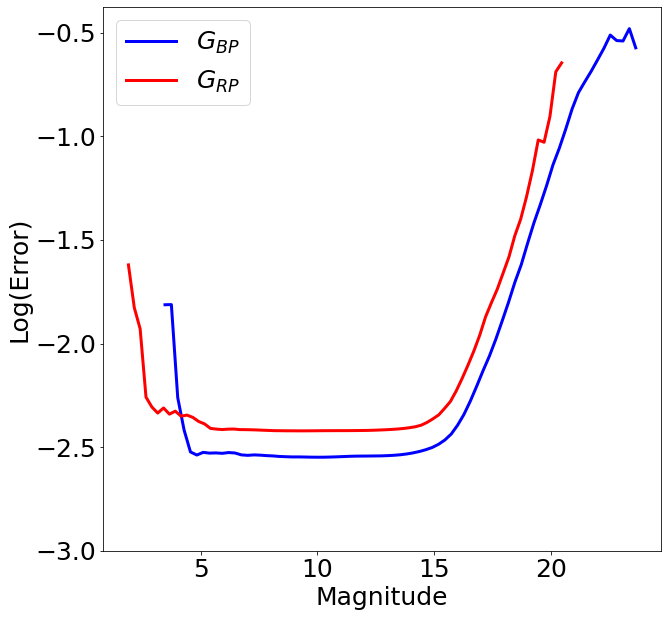

In [6]:
binnum = 75

### BP
bp_fin = np.where(np.isfinite(gaiaedr3['phot_bp_mean_mag'])==True)

bpmin = min(gaiaedr3['phot_bp_mean_mag'][bp_fin])
bpmax = max(gaiaedr3['phot_bp_mean_mag'][bp_fin])

bpdiff = bpmax-bpmin
bpfluxerr = (2.5*0.434)/gaiaedr3['phot_bp_mean_flux_over_error'][bp_fin]
bpmagerr = np.sqrt((bpfluxerr)**2+0.0027901700**2)

bpbin ,_,_ = binned_statistic(gaiaedr3['phot_bp_mean_mag'][bp_fin],np.log10(bpmagerr),'median',bins=binnum)

### RP 
rp_fin = np.where(np.isfinite(gaiaedr3['phot_rp_mean_mag'])==True)

rpmin = min(gaiaedr3['phot_rp_mean_mag'][rp_fin])
rpmax = max(gaiaedr3['phot_rp_mean_mag'][rp_fin])

rpdiff = rpmax-rpmin
rpfluxerr = (2.5*0.434)/gaiaedr3['phot_rp_mean_flux_over_error'][rp_fin]
rpmagerr = np.sqrt((rpfluxerr)**2+0.0037793818**2)

rpbin ,_,_ = binned_statistic(gaiaedr3['phot_rp_mean_mag'][rp_fin],np.log10(rpmagerr),'median',bins=binnum)

### Plot
plt.figure(figsize=[10,10])
plt.plot(np.arange(bpmin,bpmax,bpdiff/binnum),bpbin,lw=3.0,c='blue',label=r'$G_{BP}$')
plt.plot(np.arange(rpmin,rpmax,rpdiff/binnum),rpbin,lw=3.0,c='red',label=r'$G_{RP}$')
plt.legend()
plt.ylim(bottom=-3.0)
plt.xlabel('Magnitude')
plt.ylabel('Log(Error)');

bperrfunc = IUS(np.arange(bpmin,bpmax,bpdiff/binnum),bpbin)
rperrfunc = IUS(np.arange(rpmin,rpmax,rpdiff/binnum),rpbin)

bperr = 10**bperrfunc(kasc3dr17['GAIAEDR3_PHOT_BP_MEAN_MAG'])
rperr = 10**rperrfunc(kasc3dr17['GAIAEDR3_PHOT_RP_MEAN_MAG'])

# Ages and [(C+N)/Fe]

In [7]:
agesCN = Table(fits.getdata('APOKASC_rgb_SalarisCNAlpha.fits'))
ages = Table(fits.getdata('APOKASC_rgb_Sal_age_ak.fits'))

### [(C+N/Fe)]
cfrac = (10**(8.43))/(10**(8.43)+10**(7.83))
nfrac = (10**(7.83))/(10**(8.43)+10**(7.83))

cnfe = np.log10(cfrac*10**(kasc3dr17['C_FE'])+nfrac*10**(kasc3dr17['N_FE']))

In [8]:
kasc3dr17.columns

ColDefs(
    name = 'APOGEE_ID'; format = '30A'
    name = 'TELESCOPE'; format = '6A'
    name = 'FIELD'; format = '20A'
    name = 'ALT_ID'; format = '30A'
    name = 'RA'; format = 'D'
    name = 'DEC'; format = 'D'
    name = 'GLON'; format = 'D'
    name = 'GLAT'; format = 'D'
    name = 'J'; format = 'E'
    name = 'J_ERR'; format = 'E'
    name = 'H'; format = 'E'
    name = 'H_ERR'; format = 'E'
    name = 'K'; format = 'E'
    name = 'K_ERR'; format = 'E'
    name = 'AK_TARG'; format = 'E'
    name = 'AK_TARG_METHOD'; format = '32A'
    name = 'AK_WISE'; format = 'E'
    name = 'SFD_EBV'; format = 'E'
    name = 'APOGEE_TARGET1'; format = 'J'
    name = 'APOGEE_TARGET2'; format = 'J'
    name = 'APOGEE2_TARGET1'; format = 'J'
    name = 'APOGEE2_TARGET2'; format = 'J'
    name = 'APOGEE2_TARGET3'; format = 'J'
    name = 'APOGEE2_TARGET4'; format = 'J'
    name = 'TARGFLAGS'; format = '132A'
    name = 'SURVEY'; format = '32A'
    name = 'PROGRAMNAME'; format = '32A'
    name =

# Color-Color Plots

In [9]:
ebprp_ak = (ccm_alav(leff['BP'],3.1)-ccm_alav(leff['RP'],3.1))/ccm_alav(leff['K'],3.1)
ejk_ak = (ccm_alav(leff['J'],3.1)-ccm_alav(leff['K'],3.1))/ccm_alav(leff['K'],3.1)

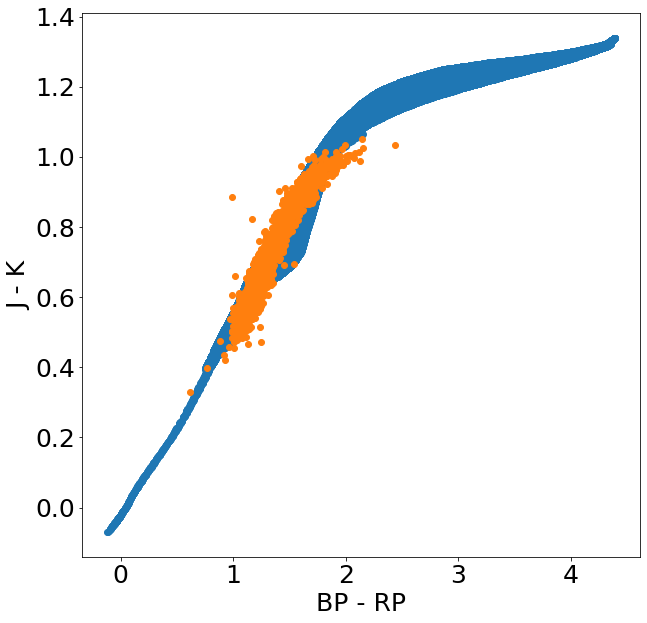

In [10]:
plt.figure(figsize=[10,10])
plt.scatter(massive['G_BPmag']-massive['G_RPmag'],massive['Jmag']-massive['Ksmag'])
plt.scatter(kasc3dr17['GAIAEDR3_PHOT_BP_MEAN_MAG']-kasc3dr17['GAIAEDR3_PHOT_RP_MEAN_MAG']-ages['AK']*ebprp_ak,
            kasc3dr17['J']-kasc3dr17['K']-ages['AK']*ejk_ak)
plt.xlabel(r'BP - RP')
plt.ylabel(r'J - K')
plt.show()

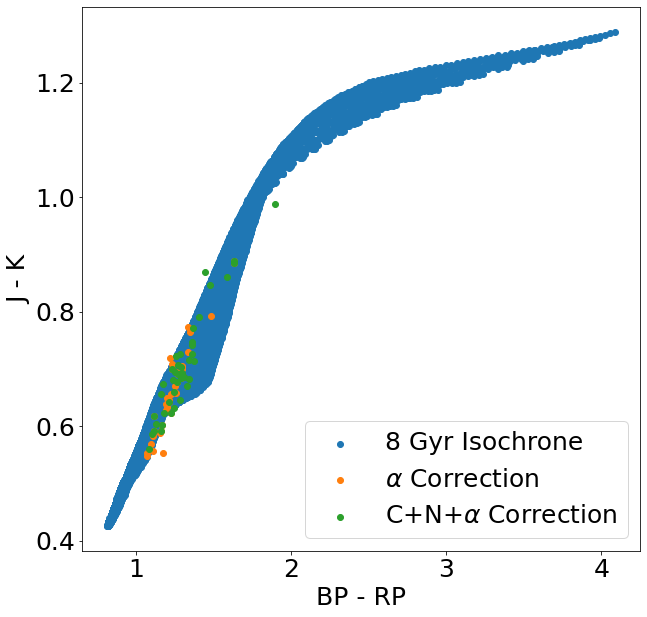

In [11]:
p8 = np.where(massive['logAge']==closest(massive['logAge'],np.log10(8*10**9)))
a8 = np.where((ages['AGE']>=7.9)&(ages['AGE']<8.1))
a8CN = np.where((agesCN['AGE']>=7.9)&(agesCN['AGE']<8.1))

plt.figure(figsize=[10,10])
plt.scatter((massive['G_BPmag']-massive['G_RPmag'])[p8],(massive['Jmag']-massive['Ksmag'])[p8],
            label='8 Gyr Isochrone')
plt.scatter((kasc3dr17['GAIAEDR3_PHOT_BP_MEAN_MAG']-kasc3dr17['GAIAEDR3_PHOT_RP_MEAN_MAG']-ages['AK']*ebprp_ak)[a8],
            (kasc3dr17['J']-kasc3dr17['K']-ages['AK']*ejk_ak)[a8],label=r'$\alpha$ Correction')
plt.scatter((kasc3dr17['GAIAEDR3_PHOT_BP_MEAN_MAG']-kasc3dr17['GAIAEDR3_PHOT_RP_MEAN_MAG']-ages['AK']*ebprp_ak)[a8CN],
            (kasc3dr17['J']-kasc3dr17['K']-ages['AK']*ejk_ak)[a8CN],label=r'C+N+$\alpha$ Correction')
plt.legend()

plt.xlabel(r'BP - RP')
plt.ylabel(r'J - K')
plt.show()

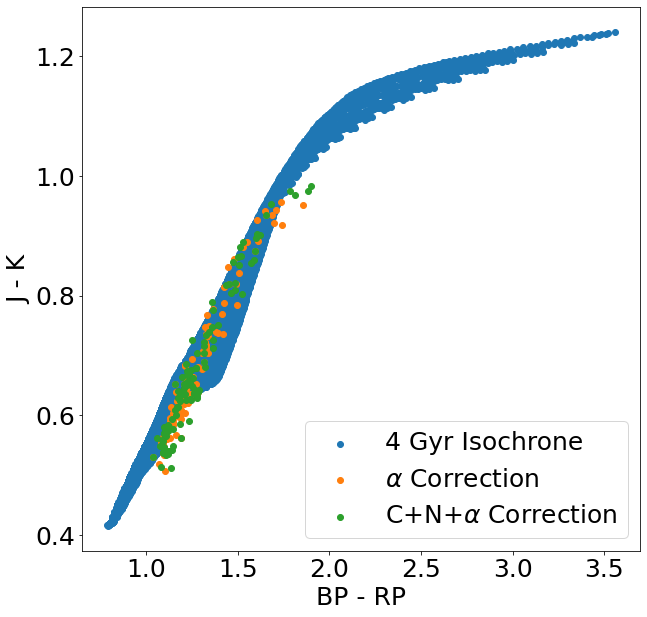

In [12]:
p4 = np.where(massive['logAge']==closest(massive['logAge'],np.log10(4*10**9)))
a4 = np.where((ages['AGE']>=3.9)&(ages['AGE']<4.1))
a4CN = np.where((agesCN['AGE']>=3.9)&(agesCN['AGE']<4.1))

plt.figure(figsize=[10,10])
plt.scatter((massive['G_BPmag']-massive['G_RPmag'])[p4],(massive['Jmag']-massive['Ksmag'])[p4],
            label='4 Gyr Isochrone')
plt.scatter((kasc3dr17['GAIAEDR3_PHOT_BP_MEAN_MAG']-kasc3dr17['GAIAEDR3_PHOT_RP_MEAN_MAG']-ages['AK']*ebprp_ak)[a4],
            (kasc3dr17['J']-kasc3dr17['K']-ages['AK']*ejk_ak)[a4],label=r'$\alpha$ Correction')
plt.scatter((kasc3dr17['GAIAEDR3_PHOT_BP_MEAN_MAG']-kasc3dr17['GAIAEDR3_PHOT_RP_MEAN_MAG']-ages['AK']*ebprp_ak)[a4CN],
            (kasc3dr17['J']-kasc3dr17['K']-ages['AK']*ejk_ak)[a4CN],label=r'C+N+$\alpha$ Correction')
plt.legend()

plt.xlabel(r'BP - RP')
plt.ylabel(r'J - K')
plt.show()